<a href="https://colab.research.google.com/github/GaganM/JAX-Tutorial/blob/main/1_Hello_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello JAX

At its core, JAX is essentially a numerical computation library, like Numpy but
with support for accelerators like GPU and TPU, and with a robust support for
differentiation (`Autograd`). In this tutorial, we'll be implementing a logistic
regression from scratch in JAX to give a very basic introduction to JAX.

## Setting Up

We start by importing some common modules. Note that JAX has it's own
implementation of `numpy`, which we commonly import as `jnp` to avoid confusing
with the default `numpy` implementation, which is usually imported as `np`.


In [1]:
import jax 
from jax import grad, numpy as jnp

import glob
import imageio
import matplotlib.pyplot as plt

Next we generate a toy dataset to run logistic regression on. We start by
generating a
[PRNG key](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html).
This is one of the interesting differences between JAX and other frameworks: JAX
explicitly requires passing a PRNG key every time to generate random numbers.
One gotcha here is that if random number generation is called with the same PRNG
key, the same set of numbers is returned. The recommended way to generate new
random numbers is to [split they key](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html)


In [39]:
key = jax.random.PRNGKey(0)
# Generating a toy dataset of 500 points and 2-dimensional data between -1 to 1.
x = jax.random.uniform(key, shape=[500,2], minval=-1.0, maxval=1.0)
# Setting a linear decision boundary for creating labels.
t = 0.5*x[:,0] + 0.75*x[:, 1] -0.3
# Creating labels based on the linear boundary.
y = (t>0).astype(float)

We add a helper method to plot points and visualize the dataset. 


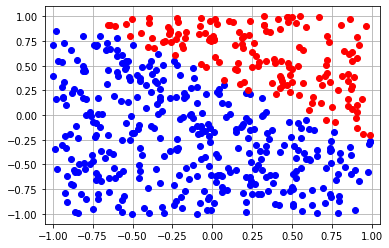

In [4]:
def plot_points(x, y, params=None):
  positive_labels = x[jnp.where(y==0.0)[0]]
  negative_labels = x[jnp.where(y==1.0)[0]]
  plt.plot(positive_labels[:, 0], positive_labels[:, 1], 'bo')
  plt.plot(negative_labels[:, 0], negative_labels[:, 1], 'ro')
  plt.xlim([-1.05,1.05])
  plt.ylim([-1.1,1.1])
  if params:
    x_range = jnp.linspace(-1.0, 1.0, 100)
    y_boundary = -params[1]/params[0][1] - params[0][0]*x_range/params[0][1]
    plt.plot(x_range, y_boundary, 'g-', linewidth='3')
  plt.grid()

plot_points(x, y)

## Defining the Model

In this section, we define the model, loss function and verify that gradient
calculation is working as expected. The model is a simple logistic regression
model, so the model looks like:

$$h_i = \sigma(W^Tx_i + b) $$

and the loss function is the standard binary cross-entropy loss: 

$$loss = -\sum_i y_i log(h_i) + (1-y_i)log (1-h_i) $$ 

We start by defining the params for our
model. Since the data is 2-dimensional, we need to define two params, the weight
matrix $W$, and the bias term $b$. Another interesting thing is that even if
params are a nested list or dictionary, `Autograd` would still work fine.


In [5]:
W = jax.random.uniform(key, shape=[2,1])
b = jax.random.uniform(key, shape=[1,])
params = [W, b]
print(params)

[DeviceArray([[0.21629536],
             [0.8041241 ]], dtype=float32), DeviceArray([0.41845703], dtype=float32)]


Next we define the model and the loss function:


In [40]:
def h_theta(params, x):
  h = x@params[0] + params[1]
  h = jax.nn.sigmoid(h)
  return h

def loss(params, x, y):
  h = h_theta(params, x)
  h = jnp.reshape(h, [-1,])
  log_h = jnp.log(h)
  inv_log_h = jnp.log(1-h)
  return -jnp.sum(log_h*y + inv_log_h*(1-y))

The simplest way gradient calculation works in JAX is by calling the `grad`
method on any function. By default, the gradient is calculated w.r.t the first
parameter of the method. For example, for a function `loss(params, x, y)`,
`grad(loss)` would return a function that calculates the gradient of the method
`loss` at `(params, x, y)` w.r.t `params`. To make sure gradient calculation is
working as expected, we can calculate the gradient manually as well.

$$ \frac{\partial h_i}{\partial W} = h_i (1-h_i)x_i$$
$$\frac{\partial h_i}{\partial b} = h_i (1-h_i)$$
$$\frac{\partial loss}{\partial W} = -\sum_i y_i\frac{\partial log(h_i)}{\partial W} + (1-y_i)\frac{\partial log(1-h_i)}{\partial W} $$
$$ = -\sum_i \frac{y_i}{h_i}h_i (1-h_i)x_i + \frac{(1-y_i)}{1-h_i}(-1)h_i(1-h_i)x_i$$
$$ = -\sum_i y_i(1-h_i)x_i - (1-y_i)h_i x_i $$
$$ = \sum_i x_i (h_i - y_i) $$
$$\frac{\partial loss}{\partial b} = \sum_i (h_i - y_i) $$

Vectorially, this can be represented as 
$$ \frac{\partial loss}{\partial W} = x^T(h-y), \frac{\partial loss}{\partial b} = (h-y)$$

$$ \nabla_\theta loss  = 
\begin{bmatrix}
\frac{\partial loss}{\partial W} \\
\\
\frac{\partial loss}{\partial b}
\end{bmatrix} = 
\begin{bmatrix}
x^T(h-y) \\
\\
h-y
\end{bmatrix}$$

We can verify this in JAX with the following code: 

In [41]:
# Calculating gradient with Autograd.
g = grad(loss)(params, x, y)
print(g)

# Calculating gradient manually.
ht = h_theta(params, x)
ht_y = (ht - jnp.reshape(y, [-1,1]))
print(jnp.transpose(x) @ ht_y)
print(jnp.sum(ht_y))

[DeviceArray([[-43.4814  ],
             [-56.080788]], dtype=float32), DeviceArray([150.28549], dtype=float32)]
[[-43.4814  ]
 [-56.080738]]
150.28549


Gradients look alright. Next we run gradient descent.

## Running Gradient Descent


In [42]:
# Create a directory for storing images.
!mkdir /content/images

To run gradient descent, we set a learning rate of `0.01` and use the standard update rule for gradient descent. 


In [ ]:
alpha = 0.01
loss_values = []

for i in range(20):
  plot_points(x, y, params)
  plt.savefig('/content/images/%03d.png'%i)
  plt.show()
  grads = grad(loss)(params, x, y)
  params[0] -= alpha * grads[0]
  params[1] -= alpha * grads[1]
  l = loss(params, x, y)
  loss_values.append(l)

We can plot the `loss_values` to see how they change with each step. 


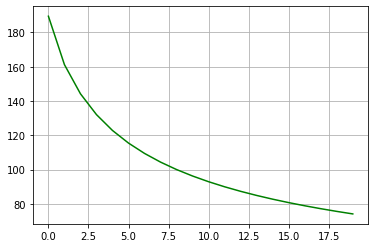

In [44]:
loss_values = [float(i) for i in loss_values] 
plt.plot(range(len(loss_values)), loss_values, 'g-')
plt.grid()

To generate a GIF of how the decision boundary changes with each step, we can run the following code: 


In [46]:
fileList = glob.glob('/content/images/*.png')
fileList.sort()

with imageio.get_writer('/content/grad_descent.gif', mode='I') as writer:
    for filename in fileList:
        image = imageio.imread(filename)
        writer.append_data(image)